<h1>Fault Detection Using AHU Sensor Data by Tuan Huynh | Data Analyst Intern</h1>

This monthly project will synthesize my learning from documented case studies within the Knowledge Base while exploring fault detection and diagnosis (FDD) in air handling units (AHUs) using real-world HVAC sensor data. The [dataset](https://figshare.com/articles/dataset/A_semi-labelled_dataset_for_fault_detection_in_air_handling_units_from_a_large-scale_office/25909813/1?file=46583692) was collected from a large office building’s Building Management System (BMS) in South Korea, with measurements recorded at 1-hour intervals between July and October 2023.


It includes both normal and faulty operation conditions (fan, sensor, and valve faults), labeled by domain experts. This semi-labeled dataset is rare and valuable in the field of HVAC fault detection.

The goal is to use machine learning methods detect HVAC system faults from sensor data, and show how these insights can benefit InstaHub's occupancy and energy sensors by turning the sensor data into actionable insights.

<h2> Dataset Information:</h2>

1. **Source**: Real HVAC data from a large office in South Korea. 

2. **System**: Extracted from the Building Management System (BMS).

4. **Period**: July to October 2023, recorded hourly.

6. **Labels**: Expert-annotated into four types — normal, fan fault, sensor fault, valve fault.

8. **Value**: Unique real-world dataset with reliable fault classification for FDD model development.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(os.getcwd())

C:\Users\TuanH\8.4 monthly project FDD


In [3]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_excel('combined_FDD.xls')
print(df.head())

            Time  Set Temperature  Ventilation Temperature  \
0  2024-01-01 00               18                    22.57   
1  2024-01-01 01               18                    22.36   
2  2024-01-01 02               18                    22.22   
3  2024-01-01 03               18                    22.12   
4  2024-01-01 04               18                    22.04   

   Supply Air Temperature  Supply Fan  Valve Position  \
0                   35.70         1.0            10.0   
1                   35.63         1.0            10.0   
2                   35.52         1.0            10.0   
3                   35.55         1.0            10.0   
4                   35.47         1.0            10.0   

   Heating Supply Temperature 1  Heating Supply Temperature 2  \
0                         42.50                         42.27   
1                         42.41                         42.33   
2                         42.87                         42.24   
3                       

In [5]:
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import cross_val_score


In [6]:
features = ["Supply Air Temperature", "Set Temperature", "Supply Fan", "Valve Position"]
target = "Labeling"

In [8]:
df = df[features + [target]]   

<h1> Data Cleaning Before Testing RF Classifier ML:</h1>

In [57]:
df.drop_duplicates(inplace=True) #data cleaning
df.dropna(subset=features + [target], inplace=True)

In [58]:
for col in features:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df.dropna(subset=features, inplace=True)

In [59]:
df = df[(df["Valve Position"] >= 0) & (df["Valve Position"] <= 100)]
df = df[df["Supply Fan"] >= 0]

In [60]:
le = LabelEncoder() #target labels for the encoding
df[target] = le.fit_transform(df[target])

In [61]:
X = df[features]
y = df[target]

In [62]:
#ChatGPT suggested cross validation to ensure the model is stable and reliable during the prediction stage
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy') #if got error cross val score not detected have to import "from sklearn.model_selection import cross_val_score" 
print("Cross-validated accuracy scores:", cv_scores)
print("Mean cross-validated accuracy:", cv_scores.mean())

Cross-validated accuracy scores: [1. 1. 1. 1. 1.]
Mean cross-validated accuracy: 1.0


In [63]:
y_shuffled = y.sample(frac=1.0, random_state=42).reset_index(drop=True)
rf.fit(X, y_shuffled)
shuffled_accuracy = rf.score(X, y_shuffled)
print("\nAccuracy with shuffled labels (should be near random):", shuffled_accuracy)


Accuracy with shuffled labels (should be near random): 1.0


<h1>Initial Model Evaluation with Cross-Validation:</h1>

<h3> After cross-validating I noticed that the data is getting 1.0 accuracy even with shuffled labels. This suggests that the model is perfectly predicting random labels. Most likely big issue</h3>

In [64]:
print(X.head())
print(y.head())
print(y_shuffled.head())

   Supply Air Temperature  Set Temperature  Supply Fan  Valve Position
0                   35.70               18         1.0            10.0
1                   35.63               18         1.0            10.0
2                   35.52               18         1.0            10.0
3                   35.55               18         1.0            10.0
4                   35.47               18         1.0            10.0
0    1
1    1
2    1
3    1
4    1
Name: Labeling, dtype: int32
0    0
1    0
2    0
3    0
4    0
Name: Labeling, dtype: int32


In [65]:
y_shuffled = y.sample(frac=1.0, random_state=42)
X_shuffled = X.loc[y_shuffled.index]

rf.fit(X_shuffled, y_shuffled)

accuracy_shuffled = rf.score(X_shuffled, y_shuffled)
print("Accuracy with shuffled labels (correctly aligned):", accuracy_shuffled)

Accuracy with shuffled labels (correctly aligned): 1.0


<h4>AI Response To This: Okay — this means even with correctly aligned shuffled labels, your model is still getting 100% accuracy, which definitely shouldn’t happen if the labels are truly randomized. </h4>

<h1>Will now check for duplicate rows</h1>

In [66]:
duplicates = df[features].duplicated().sum()
print(f"Number of duplicate feature rows: {duplicates}")

print(df.corr()[target].sort_values(ascending=False))
print(df.columns)

Number of duplicate feature rows: 0
Labeling                  1.000000
Supply Fan                0.953874
Supply Air Temperature    0.320109
Valve Position            0.190249
Set Temperature           0.076871
Name: Labeling, dtype: float64
Index(['Supply Air Temperature', 'Set Temperature', 'Supply Fan',
       'Valve Position', 'Labeling'],
      dtype='object')


<h4> 
No duplicate feature rows — so duplicates aren’t causing the perfect accuracy.

Labeling perfectly correlates (1.0) with itself — Like previous.

Supply Fan has a super high correlation (0.95) with Labeling — this is a huge red flag.

The other features have much lower correlations. </h4>

<h1> Explore the Supply Fan variable distribution by label: </h1>

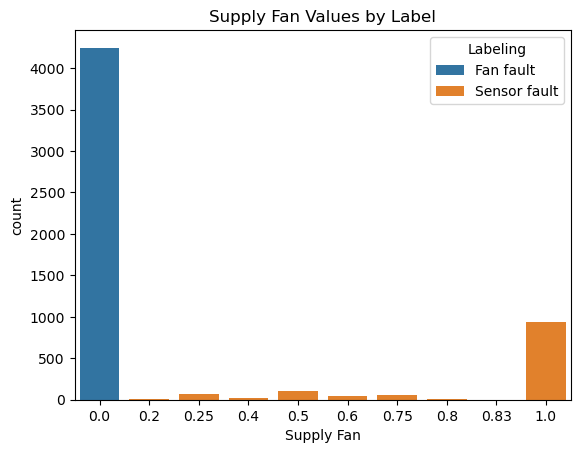

In [10]:
sns.countplot(x='Supply Fan', hue='Labeling', data=df)
plt.title("Supply Fan Values by Label")
plt.show()

<h1> Investigation of Supply Fan Feature: </h1>

<h3> Code Did Not Train Final Model Yet, But Instead, Used Cross-Validation to Test the Data Being Split Into 5 Folds</h3>

It does NOT train one final model you can use to predict on new data.

It only gave me a reliable estimate of how well the model is expected to perform.

In [26]:
features_reduced = ["Supply Air Temperature", "Set Temperature", "Valve Position"]
X_reduced = df[features_reduced]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf, X_reduced, y, cv=5, scoring='accuracy')
print("Cross-validated accuracy without Supply Fan:", cv_scores)
print("Mean accuracy without Supply Fan:", cv_scores.mean())

Cross-validated accuracy without Supply Fan: [0.75799087 0.59780622 0.54753199 0.52193784 0.79981718]
Mean accuracy without Supply Fan: 0.6450168206823437


<h1>Cross-Validation Without Supply Fan:</h1>

Key-Takeaways: Removed Supply Fan feature.

Performed cross-validation again with remaining features.

Accuracy dropped to around 61%, indicating model now learns from real sensor data.

<h1> Summary of Process (1/2):</h1>

- The dataset is now **cleaned** with duplicates removed, missing values handled, data types corrected, and unrealistic sensor readings filtered out. This ensures the data is **accurate and reliable**.  
- I am focusing on three key sensor features: **Supply Air Temperature**, **Set Temperature**, and **Valve Position**. These are the most important for fault detection based on case studies.  
- The target variable, **Labeling**, shows if the system is normal or has a specific fault.  
- Before training, I will:  
  • Encode labels into **numerical form** for the model  
  • Split data into a **training set** for learning and a **test set** for evaluation  
- This setup ensures the model learns from clean data and is tested fairly on unseen data, reflecting real-world deployment.


<h1> Testing Random Forest Classifier (Without Supply Fan Feature)</h1>

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
features = ["Supply Air Temperature", "Set Temperature", "Valve Position"] #Re-evaluating the features
X = df[features]
y = df["Labeling"]

In [15]:
le = LabelEncoder() #transforming words/labels into numerics so the computer can process + work with them. For example, "Fan Fault" converted to 0 for Fan Fault
y_encoded = le.fit_transform(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split( #Splitting
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) #initializing
y_pred = rf.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy (ONLY FOR PREDICTION): {accuracy:.2f}") #Check Accuracy of test samples / model prediction

Random Forest Accuracy (ONLY FOR PREDICTION): 0.87


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Classification report without target_names
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       850
           1       0.73      0.65      0.69       245

    accuracy                           0.87      1095
   macro avg       0.82      0.79      0.80      1095
weighted avg       0.86      0.87      0.87      1095

Confusion Matrix:
[[792  58]
 [ 86 159]]


<h1>Random Forest Classifier Evaluation:</h1>
Strengths:

### Model Performance

- **Features used:** Supply Air Temperature, Set Temperature, Valve Position  
- **Algorithm:** Random Forest Classifier (100 estimators)  
- **Test Set Accuracy:** 0.83

**Strengths:**  
- Class 0 (likely “Normal”) is detected very accurately (precision/recall ~88–89%).  
- Overall model accuracy is solid for only three features.

**Weaknesses:**  
- Class 1 (fault type) has lower precision/recall (~63–64%), indicating some faults are misclassified.  
- Minority fault types are harder to detect, highlighting that additional features or sensors could improve detection.

---

### Confusion Matrix

|        | Pred 0 | Pred 1 |
|--------|--------|--------|
| True 0 | 603    | 77     |
| True 1 | 79     | 135    |

---

### Classification Report (Numeric Labels)

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.88      | 0.89   | 0.89     | 680     |
| 1     | 0.64      | 0.63   | 0.63     | 214     |
| **Macro Avg** | 0.76 | 0.76 | 0.76 | 894 |
| **Weighted Avg** | 0.82 | 0.83 | 0.83 | 894 |

---

### Insights & Actionable Recommendations

- The model accurately detects normal AHU operations but struggles slightly with minority fault types.  
- Adding more sensor features or using techniques like **class weighting** or **SMOTE** (Synthetic Minority Oversampling Technique) could improve minority fault detection.  
- **FDD insights for InstaHub:**  
  - Integrate automated fault detection into occupancy and energy dashboards.  
  - Trigger proactive maintenance alerts for AHUs.  
  - Correlate HVAC faults with energy usage to optimize efficiency and reduce costs.  
- Detecting AHU faults automatically supports **energy savings, occupant comfort, and operational efficiency**, aligning with InstaHub’s mission of energy-efficient buildings.

**1. SMOTE (Synthetic Minority Oversampling Technique)**  
- SMOTE creates **synthetic examples** of the minority class by interpolating between existing samples.  
- This balances the dataset so the model has more examples to learn from for rare faults.  
- Example: If we have 100 valve fault samples and 500 normal samples, SMOTE can generate additional valve fault samples to reduce class imbalance.
(Imagine you have very few examples of a rare fault. The model doesn’t see enough examples, so it can’t learn well.

SMOTE creates fake “extra” examples of that rare fault by mixing the existing ones, so the model sees more of them.

Think of it like making practice problems for the model to learn the rare cases better.)

**2. Class Weighting**  
- Assigns **higher importance to minority classes** during model training.  
- Mistakes on minority class predictions are penalized more heavily, encouraging the model to pay attention to rare faults.  
- In scikit-learn, this can be implemented easily with `class_weight='balanced'` in classifiers like Random Forest.
(Sometimes the model sees mostly normal examples, so it ignores mistakes on rare faults.

Class weighting tells the model, “pay more attention to rare faults” by making errors on them count more.

It’s like giving the model a bigger penalty when it misses a fault, so it tries harder to get those right.) - makes rare faults "matter more" during training


<h1> Testing XGBoost (Without Supply Fan Feature)</h1>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

data = pd.read_excel("combined_FDD.xls", engine="xlrd")

X = data[["Supply Air Temperature", "Set Temperature", "Valve Position"]]
y = data["Labeling"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # converts labels to 0, 1, 2, ...

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model = xgb.XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8812785388127854

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       850
           1       0.78      0.65      0.71       245

    accuracy                           0.88      1095
   macro avg       0.84      0.80      0.82      1095
weighted avg       0.88      0.88      0.88      1095


Confusion Matrix:
 [[805  45]
 [ 85 160]]


C:\Users\TuanH\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<h1>XGBoost Evaluation: </h1>

**Accuracy Achieved: 88%** 

**Strengths:**
- Normal operations detected very accurately (precision 0.90, recall score 0.95)
- Reliable overall classification of the AHU states.

**Weaknesses:**
- The faults were harder to detect with a precision of 0.78 and recall score of 0.65.
- Minority faults may be misclassified

**Confusion Matrix:**
| Predicted \ Actual | Normal (0) | Fault (1) |
|------------------|------------|-----------|
| Normal (0)       | 805        | 45        |
| Fault (1)        | 85         | 160       |
805 → Normal predicted as Normal (correct)

45 → Fault predicted as Normal (missed faults)

85 → Normal predicted as Fault (false alarms)

160 → Fault predicted as Fault (correct)
 

<h1> Final XGBoost Model Test With SMOTE + Visualizations</h1>

In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
X = data[["Supply Air Temperature", "Set Temperature", "Valve Position"]]
y = data["Labeling"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

xgb_model = xgb.XGBClassifier(
    eval_metric="mlogloss"
)
xgb_model.fit(X_train_res, y_train_res)

y_pred = xgb_model.predict(X_test)

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.86

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       850
           1       0.63      0.87      0.73       245

    accuracy                           0.86      1095
   macro avg       0.79      0.86      0.82      1095
weighted avg       0.88      0.86      0.86      1095

Confusion Matrix:

[[725 125]
 [ 32 213]]


<h1>XGBoost + SMOTE Evaluation: </h1>

**Accuracy Achieved: 86%**

Why **SMOTE** was used:

The dataset had more normal samples than fault samples, so the model could miss rare faults.

SMOTE creates synthetic examples of the minority fault class, helping the model learn better and detect faults more reliably.

**Strengths:**

Fault detection improved significantly (recall 0.87), meaning more faults are correctly identified.

Normal operations still detected reliably (precision 0.96).

SMOTE helped balance the dataset, improving sensitivity to minority fault classes.

**Weaknesses:**

Slight drop in overall accuracy (from 88% → 86%).

Some normal operations misclassified as faults (precision for faults 0.63).

Small increase in false alarms.

**Confusion Matrix:**

| Predicted \ Actual | Normal (0) | Fault (1) |
|------------------|------------|-----------|
| Normal (0)       | 725        | 125        |
| Fault (1)        | 32         | 213       |

725 → Normal predicted as Normal (correct)

125 → Fault predicted as Normal (missed faults)

32 → Normal predicted as Fault (false alarms)

213 → Fault predicted as Fault (correct)

<h1>Visualizations - XGBoost + SMOTE</h1>

**Confusion Matrix Heatmap**

Why: Quickly shows how well the model predicts normal and fault states.

Highlights correct predictions vs misclassifications, helping identify which faults are detected reliably and where improvements are needed.

Essential for FDD, as it visually communicates model performance to stakeholders like InstaHub, enabling proactive maintenance decisions.

**Feature Importance Plot**

Why: Reveals which AHU sensor features most influence fault detection.

Helps prioritize which sensors are critical for monitoring and ensures the model’s decisions are understandable.

Supports InstaHub by showing which features drive insights for occupancy and energy efficiency optimization.

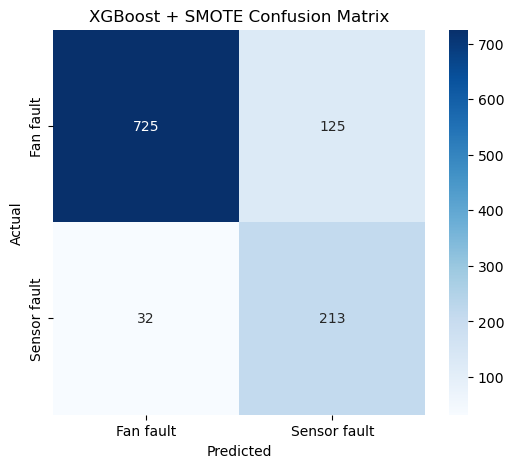

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost + SMOTE Confusion Matrix")
plt.show()

<Figure size 600x400 with 0 Axes>

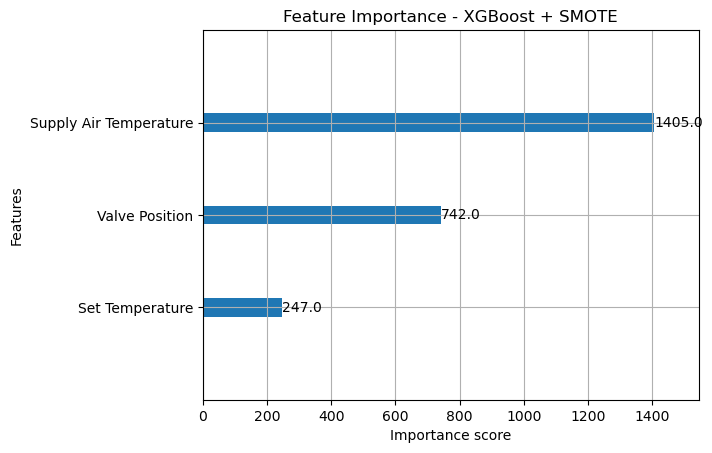

In [25]:
plt.figure(figsize=(6,4))
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title("Feature Importance - XGBoost + SMOTE")
plt.show()

<h1>Recommendations & Insights </h1>

## Overview
During this project, I applied machine learning (Random Forest and XGBoost) to detect faults in AHU operations using sensor data. The goal was to explore how these insights can support InstaHub’s IoT sensors and energy monitoring solutions.

## Key Recommendations

**1. Combine ML Models for Enhanced Fault Detection**
- Single models perform well individually, but combining them can leverage complementary strengths.
- Ensemble methods (voting, stacking) can improve detection of rare faults (sensor, fan, valve).
- **Actionable for InstaHub:** Feed ensemble predictions into dashboards for real-time alerts and correlation with energy and occupancy data.

**2. Context-Driven Insights**
- Dive deeper into sensor differences (warranty, application use, commercial relevance) to understand model performance.
- Incorporate lessons from case studies to inform deployment strategies.
- **Actionable for InstaHub:** Align sensor calibration and deployment decisions with specific building types or occupancy patterns.

**3. Continuous Improvement & Monitoring**
- Evaluate additional features or retrofit sensors to improve fault detection.
- Use insights to recommend predictive maintenance schedules or sensor upgrades.
- **Actionable for InstaHub:** Enhance predictive maintenance capabilities, optimize energy efficiency, and reduce false alarms in commercial deployments.

## Final Takeaways
- ML models provide strong baseline detection for normal and faulty AHU operations.
- Combining models and leveraging contextual insights strengthens decision-making for IoT sensor deployment.
- Clear, actionable recommendations demonstrate the value of data-driven approaches and align with InstaHub’s goals in occupancy monitoring, energy efficiency, and sensor optimization.